<a href="https://colab.research.google.com/github/robbespo00/ISPR-Midterms/blob/main/midterm-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Roberto Esposito - Midterm 1- Assignment 4**

# **Preprocessing**

In the following section it is shown:

*   How to load the dataset in order to perform the execution of the algorithm
*   How to perform I/O operations in order to read images
*   How to convert the RGB values of the Ground Truth to labels

Each of these operation is described in details in the corresponding subsection.





First of all it is needed to import all the modules required to run the Colab project.

In [ ]:
import skimage
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.future import graph
from skimage import data, segmentation, color
import glob

## Dataset

The following cell mount and unzip the [dataset](http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip) provided by Microsoft that contains 
240 manually segmented and labelled photographs. The data are loaded from Google Drive. \\
After that the Drive is mounted it is needed to insert the path to the dataset in the .zip version.

In [ ]:
from google.colab import drive 
drive.mount('/content/drive') # load the drive on Colab


!unzip '/content/drive/MyDrive/Dataset/datasetAssignment1ISPR.zip' # unzip the dataset 


# drive.flush_and_unmount() # unmount the dataset from Colab
# !rm -rf folder # remove the folder

## Read Data

At this point once the dataset is loaded in the workspace in order to perform the segmentation it is needed to read the images. 




```
def load_data()
```
This function returns a list of strings that contains the name of all the images in the dataset.

In [ ]:
def load_data():
  images = []
  for file in glob.glob("MSRC_ObjCategImageDatabase_v1/*.bmp"):
    if file.find("GT") == -1:
      images.append(file)
    
  return images

```
def read_image(filename)
```


This function, given an image name, returns the image and its ground truth.


In [ ]:
def read_image(filename):
  img = cv.imread(filename)
  img_gt = cv.imread(filename.replace(".bmp", "_GT.bmp"))
  #cv2_imshow(img)
  #cv2_imshow(img_gt)
  return img, img_gt

## **Conversion from RGB to label**

In this subsection it is converted the ground truth of the image, that it has been read, into labels and in order to perform this operations I used as reference the legend provided by the researcher that built the dataset.\
\
In fact inside the dataset it is available a HTML document called "ClickMe.html" that shows for each color the corresponding label. \

\
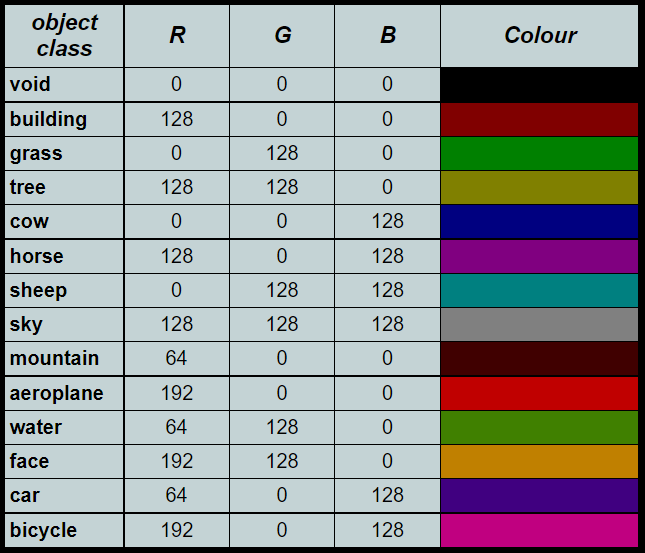

In [ ]:
label0 = (0, np.array([0, 0, 0])) # VOID
label1 = (1, np.array([0, 0, 128])) # BUILDING
label2 = (2, np.array([0, 128, 0])) # GRASS
label3 = (3, np.array([0, 128, 128])) # TREE
label4 = (4, np.array([128, 0, 0])) # COW
label5 = (5, np.array([128, 0, 128])) # HORSE
label6 = (6, np.array([128, 128, 0])) # SHEEP
label7 = (7, np.array([128, 128, 128])) # SKY
label8 = (8, np.array([0, 0, 64])) # MOUNTAIN
label9 = (9, np.array([0, 0, 192])) # AEROPLANE
label10 = (10, np.array([0, 128, 64])) # WATER
label11 = (11, np.array([0, 128, 192])) # FACE
label12 = (12, np.array([128, 0, 64])) # CAR
label13 = (13, np.array([128, 0, 192])) # BICYCLE

objects = [label0, label1, label2, label3, label4, label5, label6, label7, label8, label9, label10, label11, label12, label13]

# Given a pixel, map_label(pixel) maps the pixel with one of the 14 possible labels, -1 otherwise 
def map_label(pixel):
  for obj in objects:
    
    if np.all(pixel == obj[1]):
      return obj[0]
  
  return -1

# Given the ground truth of size n x m x 3, map_labels(img_gt) returns a matrix n x m that contains the labels for all the pixels
def map_labels(img_gt):
  gt_reshaped = img_gt.reshape(-1,3)
  labels = np.zeros((img_gt.shape[0], img_gt.shape[1]))
  for ij in np.ndindex(img_gt.shape[:2]):
    labels[ij[0]][ij[1]] = map_label(img_gt[ij])
  return labels



# **Segmentation**

At this point I start to perform the segmentation of the image and I tried two different algorithms:


1.  **Slic** that uses the K-Means clustering algorithm
2.  **Quickshift** that uses the Quick Shift clustering algorithm

In any case both of them (slic segmentation and quickshift segmentation) return the labels identified by the clustering algorithm and the image corresponding.



In [ ]:
def segmentation_slic(img):

  labels = segmentation.slic(img, compactness=30, n_segments=80, start_label=1)
  out = color.label2rgb(labels, img, kind='avg', bg_label=0)
  
  return labels, out

In [ ]:
def segmentation_quickshift(img):

  labels = segmentation.quickshift(image=img, ratio=1.0, kernel_size=5, max_dist=10, return_tree=False, sigma=0, convert2lab=True, random_seed=42)
  out = color.label2rgb(labels, img, kind='avg', bg_label=0)
  
  return labels, out

# **Ncut algorithm**

In the following section it is performed the Ncut algorithm and afterwards it is created an association between the labels identified by this algorithm and the labels identified by the Ground Truth.

In the following cell it is performed the Normalized Cut algorithm. \
\
``` def ncut(img, labels) ``` takes as input the image and the labels constructed by the segmentation and returns the labels and the corresponding image.



In [ ]:
def ncut(img, labels):

  g = graph.rag_mean_color(img, labels, mode='similarity')
  labels= graph.cut_normalized(labels, g)
  out= color.label2rgb(labels, img, kind='avg', bg_label=0)
  
  return labels, out

The cell below contains the whole implementation to perform the association. \
In particular:

*   ```def find_all(matrix, element) ```, given a matrix with labels and a specific label *l*, it returns a list containing all the position where *l* appears;
*    ```def find_score(labels_gt, positions, unique_pred) ```, given the labels of the Ground Truth, a list of positions and a label predicted. It returns the label of the Ground Truth that best match the predicted label;
*    ```def update_labels(new_labels, positions, label)```, given the new labels, the position and the new label, it performs the update of the labels;
*    ```def associate(labels_gt, labels_pred)```, given the labels of the Ground Truth and the predicted labels. It executes the functions described above for all the predicted labels and returns the new matrix with the association.







In [ ]:
def find_all(matrix, element):

    result = []

    for i in range(len(matrix)):

        for j in range(len(matrix[i])):

            if matrix[i][j] == element:
                result.append((i, j))

    return result

def find_score(labels_gt, positions, unique_pred):

  scores = np.zeros(14)

  for element in positions:

    row = element[0]
    column = element[1]
    label = int(labels_gt[row][column])

    scores[label] = scores[label] + 1
  
  max = np.max(scores)
  index = np.where(scores == max)

  return index[0]


def update_labels(new_labels, positions, label):
  
  for position in positions:

    new_labels[position[0]][position[1]] = label

  return new_labels



def associate(labels_gt, labels_pred):

  unique_gt = np.unique(labels_gt)
  unique_pred = np.unique(labels_pred)
  new_labels = np.zeros((labels_pred.shape[0], labels_pred.shape[1]))

  for i in unique_pred:
    
    positions = find_all(labels_pred, i)
    new_label = find_score(labels_gt, positions, unique_pred)
    new_labels = update_labels(new_labels, positions, new_label[0])
  
  return new_labels
      


# **Metric**

In this section it is analyzed the chosen metric to perform comparison between the output obtained by the algorithm and the Ground Truth.
One of the simplest metrics is the Pixel Accuracy, but it has been discarded since it shows **class imbalance** issue. This phenomenon happens when the classes are highly imbalanced and a class dominates the image over the other classes, obtaining high score even if the image is segmented badly. 
A better metric considered is the **intersection over union** (IoU). 

## **IoU Score**

The **IoU Score** is computed as: \
\
$$IoU=\frac{\text{Area of Overlap}}{\text{Area of Union}}$$
\
This metric considers the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth. The value ranges from [0,1] where 0 means no overlap and 1 means perfect overlapping segmentation

In [ ]:
def iou_score(y_true, y_pred):

  intersection = np.logical_and(y_true, y_pred)
  union = np.logical_or(y_true, y_pred)
  
  return np.sum(intersection) / np.sum(union)
  


# **Considerations on the results**

In the following section are shown some considerations on the results obtained performing the algorithm over the images of the dataset. There will be reported before two cases where the algorithm performed well and then two cases where it performed in a bad way. All these test cases use the **slic segmentation** since it has shown to perform in the same way with respect to **quickshift**.


The first case that it is analyzed is the image *MSRC_ObjCategImageDatabase_v1/5_29_s.bmp* that represents a cow. The **iou score** obtained is around **98%** and in general the algorithm performed good on instances of images representing cow; eventhough it showed to have difficulties to identify some details of the animals if in the image there was more than one cow.


 REAL IMAGE


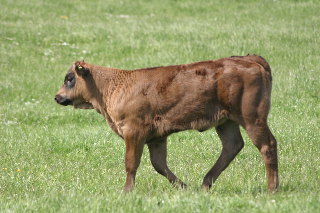


 GROUND TRUTH


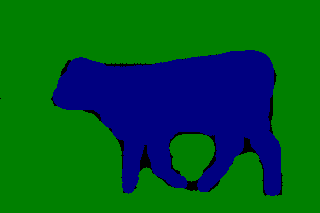


 OUTPUT NCUT


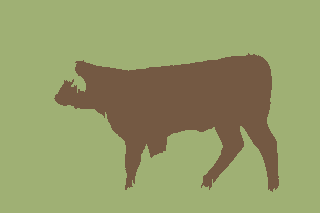


 iou score:  0.9821742957746479


In [ ]:
img, img_gt = read_image('MSRC_ObjCategImageDatabase_v1/5_29_s.bmp')
print('\n REAL IMAGE')
cv2_imshow(img)
print('\n GROUND TRUTH')
cv2_imshow(img_gt)
labels_gt = map_labels(img_gt)

labels1, out1 = segmentation_slic(img)

labels2, out2 = ncut(img, labels1)

new_labels = associate(labels_gt, labels2)

new_image = color.label2rgb(new_labels, img, kind='avg', bg_label=0)
print('\n OUTPUT NCUT')
cv2_imshow(new_image)
iou_score = iou_score(labels_gt, new_labels)
print('\n iou score: ', iou_score)

The second case that it is analyzed is the image *MSRC_ObjCategImageDatabase_v1/3_16_s.bmp* that represent a building. \
Differently from the previous example, the buildings seems to have different performance that depend on the disposition of the building in the image, but even in this case the **iou score** is pretty high; it is around **92%**.


 REAL IMAGE


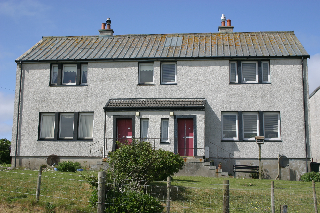


 GROUND TRUTH


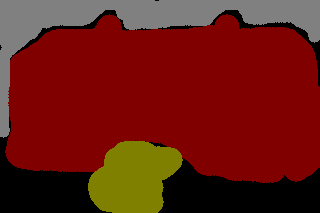


 OUTPUT NCUT


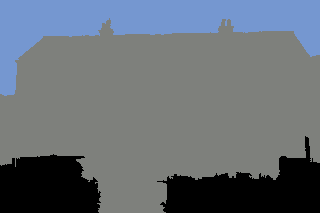

Iou score:  0.9243868516571119


In [ ]:
img, img_gt = read_image('MSRC_ObjCategImageDatabase_v1/3_16_s.bmp')
print('\n REAL IMAGE')
cv2_imshow(img)
print('\n GROUND TRUTH')
cv2_imshow(img_gt)
labels_gt = map_labels(img_gt)

labels1, out1 = segmentation_slic(img)

labels2, out2 = ncut(img, labels1)

new_labels = associate(labels_gt, labels2)

new_image = color.label2rgb(new_labels, img, kind='avg', bg_label=0)
print('\n OUTPUT NCUT')
cv2_imshow(new_image)
iou_score = iou_score(labels_gt, new_labels)
print('Iou score: ', iou_score)

Now the cases that will be analyzed are cases where the algorithm performs badly.

The first case where the algorithm does not reach a good score is given by *MSRC_ObjCategImageDatabase_v1/6_14_s.bmp* that represents a human being.\
In this instance the **IoU score** obtained is around **36%**. In general the algorithm seems to work pretty well on this kind of class except for few cases like this one reported below or cases where the face is not clearly visible because it is covered by some obstacles.


 REAL IMAGE


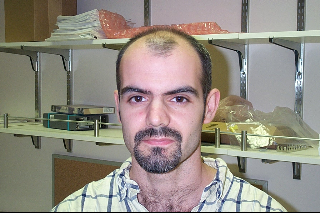


 GROUND TRUTH


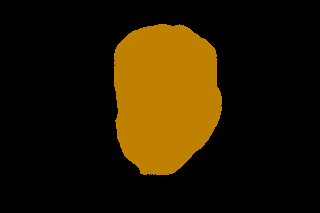


 OUTPUT NCUT


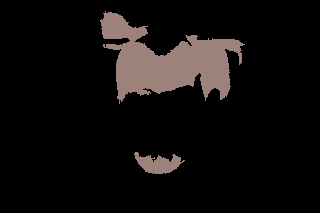

Iou score:  0.36317169950904565


In [ ]:
img, img_gt = read_image('MSRC_ObjCategImageDatabase_v1/6_14_s.bmp')
print('\n REAL IMAGE')
cv2_imshow(img)
print('\n GROUND TRUTH')
cv2_imshow(img_gt)
labels_gt = map_labels(img_gt)

labels1, out1 = segmentation_slic(img)

labels2, out2 = ncut(img, labels1)

new_labels = associate(labels_gt, labels2)

new_image = color.label2rgb(new_labels, img, kind='avg', bg_label=0)
print('\n OUTPUT NCUT')
cv2_imshow(new_image)
iou_score = iou_score(labels_gt, new_labels)
print('Iou score: ', iou_score)

The last case looks more interesting because it reports an image where the class identified is a bike, the instance is the *MSRC_ObjCategImageDatabase_v1/8_20_s.bmp*. 
The **IoU Score** is around **39%** and in general the algorithm performs badly on images where appear bikes.


 REAL IMAGE


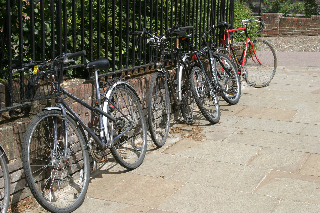


 GROUND TRUTH


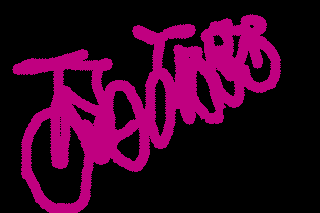


 OUTPUT NCUT


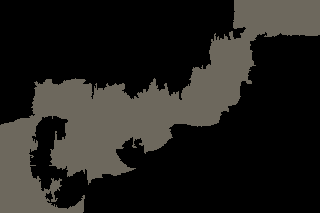

Iou score:  0.39288590134089557


In [ ]:
img, img_gt = read_image('MSRC_ObjCategImageDatabase_v1/8_20_s.bmp')
print('\n REAL IMAGE')
cv2_imshow(img)
print('\n GROUND TRUTH')
cv2_imshow(img_gt)
labels_gt = map_labels(img_gt)

labels1, out1 = segmentation_slic(img)

labels2, out2 = ncut(img, labels1)

new_labels = associate(labels_gt, labels2)

new_image = color.label2rgb(new_labels, img, kind='avg', bg_label=0)
print('\n OUTPUT NCUT')
cv2_imshow(new_image)
iou_score = iou_score(labels_gt, new_labels)
print('Iou score: ', iou_score)

In conclusion it is possible to say that the algorithm performs in a good way and the mean of the score over all the images is around **71%**. During the tests there were some instances of images that performed scores like 100%, but they have not been taken into consideration because they are not considered interesting. It happened because the images had features too detailed to be identified so the algorithm labelled the whole image with the same value.

In [ ]:
# The following code performs the algorithm over all the images showing the original image, the ground truth, 
# the result of the algorithm and the score obtained by the IoU score

images = load_data()

for image in images:

  print(image)
  img, img_gt = read_image(image)
  cv2_imshow(img)
  cv2_imshow(img_gt)
  labels_gt = map_labels(img_gt)

  labels1, out1 = segmentation_slic(img)

  labels2, out2 = ncut(img, labels1)

  new_labels = associate(labels_gt, labels2)

  new_image = color.label2rgb(new_labels, img, kind='avg', bg_label=0)

  cv2_imshow(new_image)
  iou_score = iou_score(labels_gt, new_labels)
  print('IOU: ', iou_score)